# ETA Prediction

### Problem Tanımı:

ETA (Estimated Time of Arrival) tahmini, bir kişinin, aracın veya ürünün belirli bir varış noktasına ulaşmasının ne kadar süreceğini öngörme problemidir. Temel olarak, bir hareketin başlangıç anından bitiş anına kadar geçecek olan süreyi (duration) tahmin etmekle ilgilidir.

### Kullanım Alanlar:

- Ride-Sharing (Yolculuk Paylaşımı) Hizmetleri (Uber, Lfyt, Didi)
    - Uber: https://www.uber.com/en-TR/blog/deepeta-how-uber-predicts-arrival-times/
    - Lyft: https://eng.lyft.com/eta-estimated-time-of-arrival-reliability-at-lyft-d4ca2720bda8
    - Didi: https://dl.acm.org/doi/abs/10.1145/3219819.3219900


- Food & Grocery Delivery (Doordash, Trendyol GO, Getir)
    - Doordash: https://careersatdoordash.com/blog/improving-eta-prediction-accuracy-for-long-tail-events/
    - Doordash: https://careersatdoordash.com/blog/using-gamma-distribution-to-improve-long-tail-event-predictions/
    - Doordash: https://careersatdoordash.com/blog/solving-for-unobserved-data-in-a-regression-model/

### Problemin Zorlukları:

1. Dinamik Çevresel Faktörler:
- Trafik Durumu: Sadece yoğunluk değil, aynı zamanda kazalar, yol çalışmaları ve beklenmedik tıkanıklıklar gibi gerçek zamanlı olaylar süreyi anlık olarak değiştirebilir.

- Hava Koşulları: Yağmur, kar, sis gibi olumsuz hava şartları, hız limitlerini düşürerek ve görüş mesafesini azaltarak süreyi uzatır.

- Saatlik Değişimler: Günün saati (işe gidiş/dönüş saatleri) ve haftanın günü (hafta içi/hafta sonu) gibi döngüsel desenler büyük farklılıklara yol açar.

2. Veri Kalitesi ve Eksikliği:
- GPS Verisi Kusurları: GPS sinyalinin kaybolması, yanlış raporlanması veya gecikmeli gelmesi tahmini bozabilir.

- Rota Belirsizliği: Özellikle yayalar veya bisikletler için, modelin tahmin ettiği rota ile kullanıcının izleyeceği gerçek rota farklı olabilir.

3. Hesaplama Zorlukları:
- Büyük Ölçek: Milyonlarca olası başlangıç-bitiş çifti ve sürekli değişen trafik koşulları için hızlı ve düşük gecikmeli (low-latency) tahminler üretmek ciddi bir hesaplama gücü gerektirir.

- Uzun Mesafeler: Özellikle lojistikte uzun mesafeler söz konusu olduğunda, yol boyunca hava durumu, sınır geçişleri ve mola zorunlulukları gibi değişkenler belirsizliği artırır.

### Proje:

Projenin amacı New York City'deki taksi yolculuklarının süresini doğru bir şekilde tahmin eden bir model oluşturmaktır. 

https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview

#### Feature'lar:

- id - Her yolculuk için benzersiz tanımlayıcı
- vendor_id - Yolculuk kaydıyla ilişkili sağlayıcıyı (şirketi) belirten kod
- pickup_datetime - Taksimetrenin başlatıldığı zaman
- dropoff_datetime - Taksimetrenin durdurulduğu zaman
- passenger_count - Araçtaki yolcu sayısı (sürücü tarafından girilen değer)
- pickup_longitude - TaksimetreninTaksimetrenin başlatıldığı boylam
- pickup_latitude - TaksimetreninTaksimetrenin başlatıldığı enlem
- dropoff_longitude - TaksimetreninTaksimetrenin durdurulduğu boylam
- dropoff_latitude - TaksimetreninTaksimetrenin durdurulduğu enlem
- store_and_fwd_flag - Bu işaret, araç sunucuya bağlantı kuramadığı için yolculuk kaydının sağlayıcıya gönderilmeden önce araç belleğinde tutulup tutulmadığını gösterir. Y=tutuldu ve iletildi (store and forward); N=tutulmadı ve iletilmedi (not a store and forward trip)
- trip_duration - Yolculuğun saniye cinsinden süresi (TARGET)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import scipy.stats as stats
import warnings
import math
import h3

In [2]:
from sklearn.decomposition import PCA

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


## Explatory Data Analysis

In [5]:
pd.set_option('display.float_format', lambda x: '%.6f' % x)

In [7]:
len(train)

1458644

In [6]:
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000,1458644.000000
mean,1.534950,1.664530,-73.973486,40.750921,-73.973416,40.751800,959.492273
std,0.498777,1.314242,0.070902,0.032881,0.070643,0.035891,5237.431724
min,1.000000,0.000000,-121.933342,34.359695,-121.933304,32.181141,1.000000
25%,1.000000,1.000000,-73.991867,40.737347,-73.991325,40.735885,397.000000
50%,2.000000,1.000000,-73.981743,40.754101,-73.979752,40.754524,662.000000
75%,2.000000,2.000000,-73.967331,40.768360,-73.963013,40.769810,1075.000000
max,2.000000,9.000000,-61.335529,51.881084,-61.335529,43.921028,3526282.000000


In [116]:
3526282.000000 / 60 / 60 

979.5227777777778

Çıkarımlar:

- trip_duration: Yüksek Outlier değerler ve 1 sn gibi gerçek hayatta mümkün olmayan eta değerler mevcut.
- passenger_count için dağılımlar incelenebilir.
- latitude ve longitude değerlerinde outlier lar mevcut.

In [8]:
train.isna().sum() / len(train)

id                   0.000000
vendor_id            0.000000
pickup_datetime      0.000000
dropoff_datetime     0.000000
passenger_count      0.000000
pickup_longitude     0.000000
pickup_latitude      0.000000
dropoff_longitude    0.000000
dropoff_latitude     0.000000
store_and_fwd_flag   0.000000
trip_duration        0.000000
dtype: float64

array([[<Axes: title={'center': 'vendor_id'}>,
        <Axes: title={'center': 'passenger_count'}>,
        <Axes: title={'center': 'pickup_longitude'}>],
       [<Axes: title={'center': 'pickup_latitude'}>,
        <Axes: title={'center': 'dropoff_longitude'}>,
        <Axes: title={'center': 'dropoff_latitude'}>],
       [<Axes: title={'center': 'trip_duration'}>, <Axes: >, <Axes: >]],
      dtype=object)

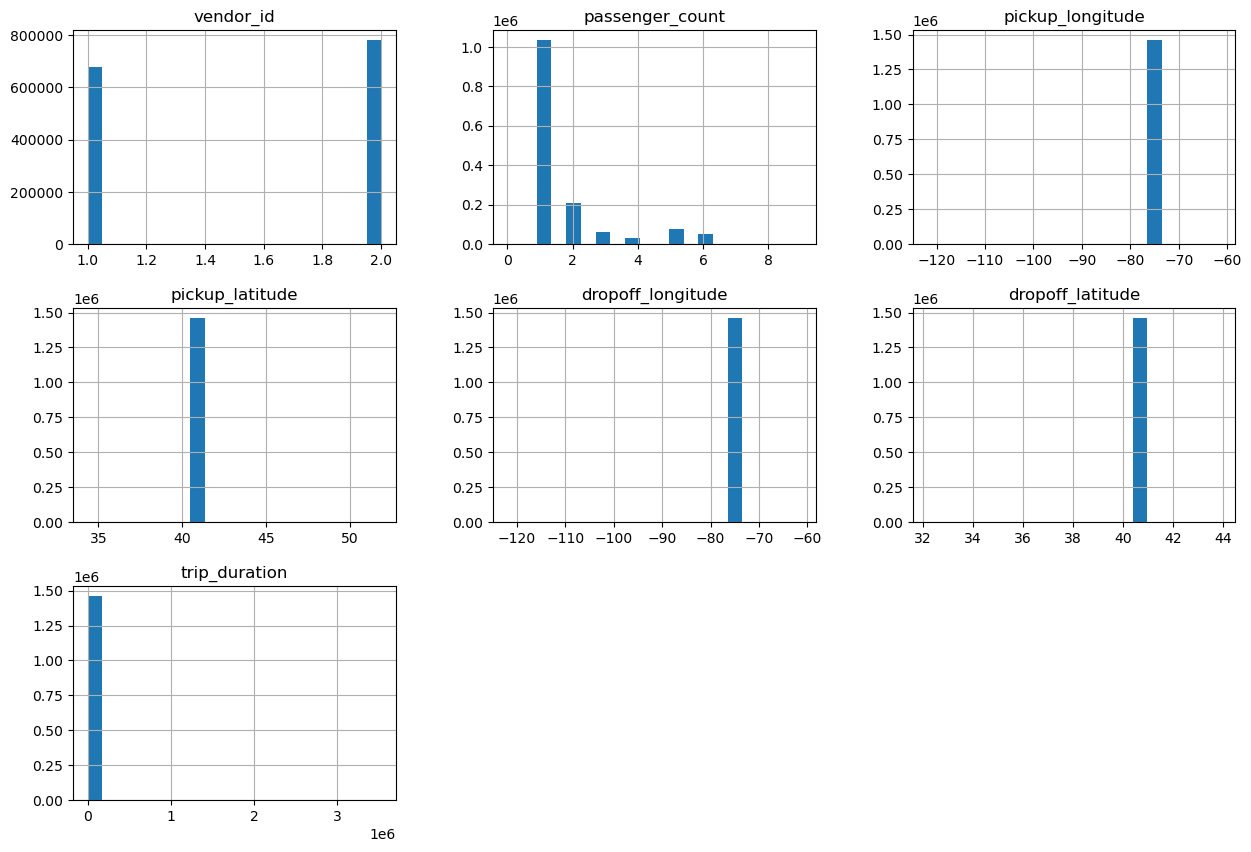

In [9]:
train.hist(bins = 20, figsize = (15, 10))

### Trip Duration

In [10]:
train.trip_duration.quantile([0.01, 0.05, 0.1])

0.010000    87.000000
0.050000   180.000000
0.100000   245.000000
Name: trip_duration, dtype: float64

In [11]:
train.trip_duration.quantile([0.99, 0.995, 0.996, 0.997, 0.998, 0.999])

0.990000    3440.000000
0.995000    4139.000000
0.996000    4403.000000
0.997000    4764.071000
0.998000    5551.714000
0.999000   85128.357000
Name: trip_duration, dtype: float64

In [12]:
train.trip_duration.quantile([0.998, 0.9985, 0.9986, 0.9987, 0.9988, 0.999])

0.998000    5551.714000
0.998500    8041.497000
0.998600   27014.435000
0.998700   80125.564000
0.998800   83517.054400
0.999000   85128.357000
Name: trip_duration, dtype: float64

In [13]:
print(len(train[(train.trip_duration < 180)]) / len(train))
print(len(train[(train.trip_duration > 8041.497000)]) / len(train))

0.04936365555954709
0.001500023309320163


### Passenger Count

In [14]:
train.groupby("passenger_count").count()[["trip_duration"]]

,trip_duration
passenger_count,
0,60
1,1033540
2,210318
3,59896
4,28404
5,78088
6,48333
7,3
8,1


### Final

In [15]:
train = train[(train.trip_duration >= 180) & 
              (train.trip_duration <= 8041.497000) & 
              (train.passenger_count > 0) & 
              (train.passenger_count < 9)]

<Axes: >

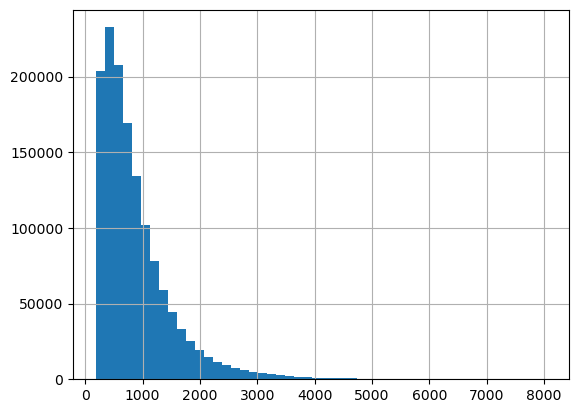

In [17]:
train.trip_duration.hist(bins = 50)

## Feature Engineering

In [20]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime)
train['store_and_fwd_flag'] = 1 * (train.store_and_fwd_flag.values == 'Y')

In [21]:
train.loc[:, 'pickup_weekday'] = train['pickup_datetime'].dt.weekday
train.loc[:, 'pickup_hour'] = train['pickup_datetime'].dt.hour
train.loc[:, 'pickup_minute'] = train['pickup_datetime'].dt.minute
train.loc[:, 'pickup_week_hour'] = train['pickup_weekday'] * 24 + train['pickup_hour']

In [22]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

pca = PCA().fit(coords)
train['pickup_pca0'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 0]
train['pickup_pca1'] = pca.transform(train[['pickup_latitude', 'pickup_longitude']])[:, 1]
train['dropoff_pca0'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 0]
train['dropoff_pca1'] = pca.transform(train[['dropoff_latitude', 'dropoff_longitude']])[:, 1]

/Users/ozgeusta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/ozgeusta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/ozgeusta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(
/Users/ozgeusta/anaconda3/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but PCA was fitted without feature names
  warnings.warn(


In [23]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [24]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
train.loc[:, 'pca_manhattan'] = np.abs(train['dropoff_pca1'] - train['pickup_pca1']) + np.abs(train['dropoff_pca0'] - train['pickup_pca0'])

In [25]:
df_counts = train.set_index('pickup_datetime')[['id']].sort_index()
df_counts['count_60min'] = df_counts.isnull().rolling('60min').count()['id']
train = train.merge(df_counts, on='id', how='left')

### h3

- https://h3geo.org/docs/community/bindings
- https://github.com/uber/h3-py
- https://h3geo.org/

In [26]:
H3_RESOLUTION = 7

In [27]:
def get_h3_index(row):

    return h3.latlng_to_cell(
        lat=row['pickup_latitude'], 
        lng=row['pickup_longitude'], 
        res=H3_RESOLUTION
    )

In [28]:
train['pickup_h3'] = train.apply(
    get_h3_index, 
    axis=1
)

In [33]:
train.pickup_h3.nunique()

273

In [46]:
train.groupby("pickup_h3").count()[["trip_duration"]].sort_values(by = "trip_duration", ascending = False).head(20)

,trip_duration
pickup_h3,
872a100d6ffffff,319182
872a100d2ffffff,294575
872a1072cffffff,154682
872a10089ffffff,140815
872a10725ffffff,77365
872a1008bffffff,75928
872a10088ffffff,44991
872a10728ffffff,42510
872a10721ffffff,40746


In [29]:
df_h3_counts = train.set_index('pickup_datetime')[['id', 'pickup_h3']].sort_index()
df_h3_counts['h3_count_60min'] = df_h3_counts.groupby('pickup_h3')['id'].transform(
    lambda x: x.isnull().rolling('60min').count()
)
train = train.merge(df_h3_counts, on=['id', 'pickup_h3'], how='left')

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384439 entries, 0 to 1384438
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1384439 non-null  object        
 1   vendor_id           1384439 non-null  int64         
 2   pickup_datetime     1384439 non-null  datetime64[ns]
 3   dropoff_datetime    1384439 non-null  datetime64[ns]
 4   passenger_count     1384439 non-null  int64         
 5   pickup_longitude    1384439 non-null  float64       
 6   pickup_latitude     1384439 non-null  float64       
 7   dropoff_longitude   1384439 non-null  float64       
 8   dropoff_latitude    1384439 non-null  float64       
 9   store_and_fwd_flag  1384439 non-null  int64         
 10  trip_duration       1384439 non-null  int64         
 11  log_trip_duration   1384439 non-null  float64       
 12  pickup_date         1384439 non-null  object        
 13  pickup_weekd

In [58]:
model_base_columns = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                     'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                     'pickup_weekday', 'pickup_hour', 'pickup_minute', 'pickup_week_hour']

In [49]:
model_columns = ['vendor_id', 'passenger_count', 'pickup_longitude', 'pickup_latitude',
                 'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
                 'pickup_weekday', 'pickup_hour', 'pickup_minute', 'pickup_week_hour', 
                 'pickup_pca0', 'pickup_pca1', 'dropoff_pca0', 'dropoff_pca1', 
                 'distance_haversine', 'direction', 'pca_manhattan', 
                 'count_60min','h3_count_60min']

In [50]:
train[model_columns].describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_weekday,pickup_hour,pickup_minute,pickup_week_hour,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,distance_haversine,direction,pca_manhattan,count_60min,h3_count_60min
count,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000,1384439.000000
mean,1.535116,1.667345,-73.973540,40.750625,-73.973478,40.751515,0.005515,3.045284,13.649359,29.580454,86.736176,0.000051,-0.000443,-0.000051,0.000443,3.584158,-15.406167,0.047898,383.443578,54.773197
std,0.498765,1.314980,0.072017,0.032788,0.071745,0.035957,0.074057,1.950456,6.378850,17.317544,46.708585,0.071984,0.032860,0.071884,0.035677,4.347341,104.769244,0.060760,107.261771,41.093841
min,1.000000,1.000000,-121.933342,34.359695,-121.933304,32.181141,0.000000,0.000000,0.000000,0.000000,0.000000,-12.498967,-6.740812,-12.498967,-8.567784,0.000000,-179.992701,0.000000,1.000000,1.000000
25%,1.000000,1.000000,-73.991974,40.737080,-73.991379,40.735363,0.000000,1.000000,9.000000,15.000000,45.000000,-0.006555,-0.013229,-0.010866,-0.015020,1.335016,-125.016115,0.017448,340.000000,17.000000
50%,2.000000,1.000000,-73.981888,40.753716,-73.979874,40.754250,0.000000,3.000000,14.000000,30.000000,89.000000,0.007921,0.002920,0.006210,0.003321,2.203261,8.299256,0.028849,395.000000,48.000000
75%,2.000000,2.000000,-73.967766,40.768009,-73.963257,40.769356,0.000000,5.000000,19.000000,45.000000,128.000000,0.018846,0.015825,0.018161,0.017724,4.035868,54.544476,0.052774,454.000000,88.000000
max,2.000000,6.000000,-61.335529,51.881084,-61.335529,43.921028,1.000000,6.000000,23.000000,59.000000,167.000000,48.060999,11.068422,48.060955,3.409578,1240.908677,180.000000,12.991565,633.000000,197.000000


## Modelling

In [55]:
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error
from lightgbm import LGBMRegressor
import lightgbm as lgb

In [42]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1384439 entries, 91539 to 475106
Data columns (total 27 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   id                  1384439 non-null  object        
 1   vendor_id           1384439 non-null  int64         
 2   pickup_datetime     1384439 non-null  datetime64[ns]
 3   dropoff_datetime    1384439 non-null  datetime64[ns]
 4   passenger_count     1384439 non-null  int64         
 5   pickup_longitude    1384439 non-null  float64       
 6   pickup_latitude     1384439 non-null  float64       
 7   dropoff_longitude   1384439 non-null  float64       
 8   dropoff_latitude    1384439 non-null  float64       
 9   store_and_fwd_flag  1384439 non-null  int64         
 10  trip_duration       1384439 non-null  int64         
 11  log_trip_duration   1384439 non-null  float64       
 12  pickup_date         1384439 non-null  object        
 13  pickup_weekday

In [35]:
train.sort_values(by = "pickup_datetime", inplace = True)

<Axes: >

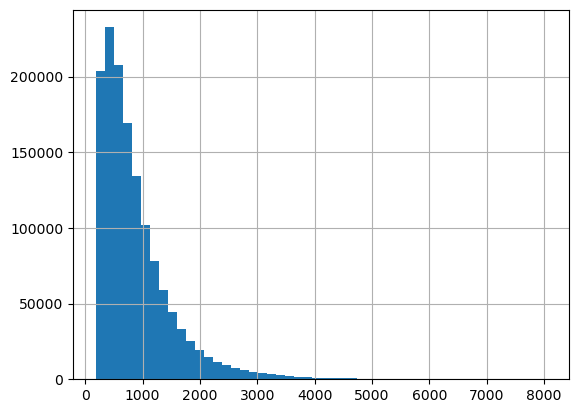

In [74]:
train.trip_duration.hist(bins = 50)

In [75]:
train.trip_duration.describe()

count   1384439.000000
mean        873.508202
std         651.517823
min         180.000000
25%         433.000000
50%         692.000000
75%        1103.000000
max        8041.000000
Name: trip_duration, dtype: float64

In [76]:
train.trip_duration.quantile([0.9])

0.900000   1658.000000
Name: trip_duration, dtype: float64

In [112]:
def regression_metric_calculation(y_true, y_pred, low_thr = 600, mid_thr = 1800):

    """
    It calculates the metrics based on different segments
    """
    
    df = pd.DataFrame({"y_true": y_true, "y_pred": y_pred})
    
    conditions = [
        (df["y_true"] <= low_thr),
        (df["y_true"] > low_thr) & (df["y_true"] <= mid_thr),
        (df["y_true"] >= mid_thr)
    ]
    choices = ["Low", "Mid", "High"]
    df["segment"] = np.select(conditions, choices)
    
    for seg in ["Low", "Mid", "High"]:
        sub = df[df["segment"] == seg]
        if len(sub) > 0:
            mae = mean_absolute_error(sub["y_true"], sub["y_pred"])
            rmse = np.sqrt(mean_squared_error(sub["y_true"], sub["y_pred"]))
            print(f"{seg} Segment: MAE {mae:.2f}, RMSE {rmse:.2f}")

In [100]:
def cv_model_training(X, y, params, n_splits=4, random_state=42, eval_metric = "mean_squared_error"):

    rmses, maes, best_iters = [], [], []
    tscv = TimeSeriesSplit(n_splits=n_splits)

    for tr_idx, te_idx in tscv.split(X, y):
        X_tr, X_test  = X.iloc[tr_idx], X.iloc[te_idx]
        y_tr, y_test  = y.iloc[tr_idx], y.iloc[te_idx]

        X_tr, X_val, y_tr, y_val = train_test_split(
            X_tr, y_tr, test_size=0.2, shuffle = False
        )
        
        model = LGBMRegressor(**params)
        model.fit(
            X_tr, y_tr,
            eval_set=[(X_val, y_val)],
            eval_metric = eval_metric,
            callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=0)]
        )

        y_pred = model.predict(X_test)

        rmses.append(np.sqrt(mean_squared_error(y_test, y_pred)))        
        maes.append(mean_absolute_error(y_test, y_pred))
        best_iters.append(model.best_iteration_)

    return rmses, maes, best_iters

In [39]:
params_default = {
 'learning_rate': 0.05,
 'num_leaves': 100,
 'lambda_l2': 1.0,
 'max_depth': 10,
 'verbosity': -1,
 'seed': 42}

In [101]:
rmses, maes, _ = cv_model_training(train[model_base_columns], train.trip_duration, params_default)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 89588
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 107198
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 112879
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 139518


In [102]:
np.mean(rmses), np.mean(maes)

(349.49572236519145, 230.67920548110814)

In [103]:
rmses, maes

([318.2960892518699, 327.7638671772995, 376.23525674933984, 375.6876762822566],
 [213.96983079644684,
  220.83476899027045,
  242.76578843604727,
  245.14643370166797])

In [104]:
rmses, maes, _ = cv_model_training(train[model_columns], train.trip_duration, params_default)

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 73971.2
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 88128.6
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 90684.2
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's l2: 116068


In [105]:
np.mean(rmses), np.mean(maes)

(318.6311738416764, 196.86397444986318)

In [106]:
rmses, maes

([287.54825911357767,
  296.58199357672413,
  344.56518425799317,
  345.8292584184104],
 [180.96428029577334,
  188.80795705562855,
  207.77985677644097,
  209.90380367160992])

In [110]:
def model_training(X, y, params):
    
    model = LGBMRegressor(**params)
    model.fit(X, y)

    y_pred = model.predict(X)

    print(f"Root Mean squared error: {np.square(mean_squared_error(y, y_pred))}")        
    print(f"Mean absolute error: {mean_absolute_error(y, y_pred)}")
    regression_metric_calculation(y, y_pred)
    
    return model, y_pred

In [113]:
model, y_pred = model_training(train[model_columns], train.trip_duration, params_default)

Root Mean squared error: 8449355368.947446
Mean absolute error: 193.21734673532364
Low Segment: MAE 120.79, RMSE 153.71
Mid Segment: MAE 195.53, RMSE 260.44
High Segment: MAE 558.08, RMSE 774.59


(array([5.45573e+05, 4.02634e+05, 2.11300e+05, 1.05521e+05, 5.26240e+04,
        2.73910e+04, 1.57610e+04, 9.31200e+03, 5.61200e+03, 3.40800e+03,
        2.14100e+03, 1.33700e+03, 7.57000e+02, 4.65000e+02, 2.59000e+02,
        1.42000e+02, 9.60000e+01, 4.20000e+01, 4.20000e+01, 2.20000e+01]),
 array([ 180.  ,  573.05,  966.1 , 1359.15, 1752.2 , 2145.25, 2538.3 ,
        2931.35, 3324.4 , 3717.45, 4110.5 , 4503.55, 4896.6 , 5289.65,
        5682.7 , 6075.75, 6468.8 , 6861.85, 7254.9 , 7647.95, 8041.  ]),
 <BarContainer object of 20 artists>)

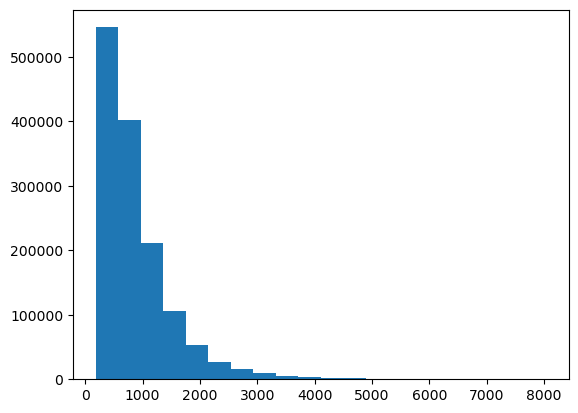

In [114]:
plt.hist(train.trip_duration, bins = 20)

(array([2.98726e+05, 3.74335e+05, 2.57512e+05, 1.64946e+05, 1.08713e+05,
        6.83640e+04, 3.78740e+04, 2.09150e+04, 1.51340e+04, 1.15180e+04,
        8.68300e+03, 5.78900e+03, 3.74300e+03, 2.74300e+03, 2.13800e+03,
        1.64400e+03, 7.07000e+02, 6.60000e+02, 2.76000e+02, 1.90000e+01]),
 array([ 216.74972484,  457.24793575,  697.74614666,  938.24435757,
        1178.74256847, 1419.24077938, 1659.73899029, 1900.2372012 ,
        2140.73541211, 2381.23362302, 2621.73183392, 2862.23004483,
        3102.72825574, 3343.22646665, 3583.72467756, 3824.22288846,
        4064.72109937, 4305.21931028, 4545.71752119, 4786.2157321 ,
        5026.713943  ]),
 <BarContainer object of 20 artists>)

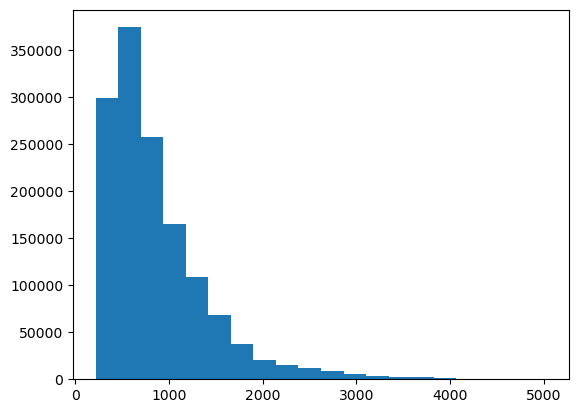

In [115]:
plt.hist(y_pred, bins = 20)